# American Sign Language (ASL) Image Recognition

## Loading in dataset

In [2]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile  
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm
import tensorboard

# For compiling model
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D

# For transfer learning
import scipy
# import keras.applications.resnet50 as resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# For confusion matrix calculation/visualization
import tensorflow as tf
# import seaborn as sn
import pandas as pd

from livelossplot import PlotLossesKeras

models_dir = 'models'
data_dir = 'data'
dataset_name = 'pruned2x2'
# data_dir = 'data2'
# dataset_name = 'pruned2'
bottleneck_feat_dir = 'bottleneck_features'

### Dividing data into training, validation, and testing sets

The full dataset has been split into training, validation, and testing sets. The testing set will be all the images from one subject to mirror the "Spelling It Out" paper's method so the benchmark model can be compared. The rest of the images will be randomly split; 80% of images for training, 20% of the images for validation.

In [3]:
def load_dataset(path, n_categories=24):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    # Hot encode categories to matrix
    image_targets = np_utils.to_categorical(np.array(data['target']), n_categories)
    return image_files, image_targets

def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)
    
    return load_dataset(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)
    
    return (load_dataset(train_dir), load_dataset(valid_dir))

In [4]:
# Manually set if the data is RGB
is_rgb = True

test_data, test_targets = get_testing_data(data_dir)
train, valid = get_training_validation_data(data_dir)
# Separated data and its targets
train_data, train_targets = train
valid_data, valid_targets = valid

## Basic CNN model from scratch

### Preparing the model

In [5]:
basic_img_size = 160
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(basic_img_size, basic_img_size), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
valid_tensors = paths_to_tensor(valid_data).astype('float32')
test_tensors = paths_to_tensor(test_data).astype('float32')

100%|██████████| 3186/3186 [00:03<00:00, 837.34it/s]


In [7]:
# Prepare training data separately since this is usually large
train_tensors = paths_to_tensor(train_data).astype('float32')

100%|██████████| 10590/10590 [00:11<00:00, 909.14it/s]


### Building basic model

In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from livelossplot import PlotLossesKeras

model = Sequential()
#Convo 224, 224, 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(basic_img_size, basic_img_size, 3)))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(GlobalAveragePooling2D())
#Dense; 24 for each handshape 
model.add(Dense(24, activation='softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      208       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 32)        2080      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 40, 40, 64)        8256      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 20, 20, 64)      

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training basic model

In [77]:
# from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=15, 
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2, 
#                                    horizontal_flip = 'true')
                                     
# # Create validation generator
# val_datagen = ImageDataGenerator()

# train_generator = train_datagen.flow(train_tensors, train_targets, batch_size=20)
# val_generator = val_datagen.flow(valid_tensors, valid_targets, batch_size=20)
# input_shape = (basic_img_size, basic_img_size, 3)

# epochs = 32
# batch_size=20

# # Create a saved models directory
# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

# checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
#                                verbose=1, save_best_only=True)
                               
# model.fit(train_generator, 
#           validation_data=(val_generator),
#           epochs=epochs, callbacks=[checkpointer, PlotLossesKeras()], verbose=1)

In [12]:
from keras.callbacks import ModelCheckpoint  

epochs = 4
batch_size=32

# Create a saved models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
                               
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, PlotLossesKeras()], verbose=1)

Epoch 1/12
326/331 [============================>.] - ETA: 0s - loss: 3.9455 - accuracy: 0.0711

KeyboardInterrupt: 

In [89]:
model_details = 'basic_{}_batch{}_epoch{}_data{}.h5'.format("cnn",batch_size,epochs,dataset_name)
model.summary()
model.save(model_details)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 160, 160, 16)      208       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 80, 80, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 80, 80, 32)        2080      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 40, 40, 64)        8256      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 64)      

In [80]:
# def img_resize(width, height, img_file, new_name=None):
#     img_path = os.path.join('images', img_file)
#     img = Image.open(img_path)
#     img = img.resize((width, height))
#     if new_name != None:
#         img_path = os.path.join('images', new_name)
#     img.save(img_path)
#     return img_path

# img_path = img_resize(basic_img_size, basic_img_size, "hand.jpg", "hand.jpg")
# tensor = path_to_tensor(img_path)
# model = tf.keras.models.load_model("models/basic_h5_model_epoch32.h5")
# prediction = (model.predict(tensor))
# classification = np.argmax(prediction,axis=1)
# print(prediction)
# print(classification)

### Evaluating basic model

In [81]:
handshape_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
print(handshape_predictions)
# report test accuracy
test_accuracy = 100*np.sum(np.array(handshape_predictions)==np.argmax(test_targets, axis=1))/len(handshape_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

[22, 10, 20, 7, 17, 17, 17, 4, 1, 19, 11, 2, 19, 20, 11, 4, 7, 17, 19, 0, 12, 0, 22, 4, 5, 7, 14, 21, 18, 18, 11, 7, 23, 1, 4, 7, 17, 10, 14, 5, 20, 18, 6, 12, 5, 17, 17, 19, 1, 11, 13, 21, 20, 22, 9, 6, 10, 7, 18, 13, 7, 17, 6, 2, 3, 13, 20, 10, 18, 9, 4, 17, 9, 21, 10, 2, 19, 11, 13, 13, 13, 20, 19, 22, 15, 19, 4, 12, 6, 4, 8, 18, 19, 11, 3, 6, 21, 3, 20, 1, 17, 5, 20, 19, 17, 13, 6, 4, 21, 4, 20, 13, 11, 23, 4, 19, 19, 21, 5, 19, 10, 4, 20, 19, 9, 17, 0, 20, 19, 19, 18, 20, 11, 8, 20, 17, 19, 5, 0, 1, 20, 8, 17, 19, 19, 10, 7, 0, 20, 10, 20, 10, 4, 21, 10, 10, 15, 19, 10, 10, 12, 2, 19, 12, 20, 12, 13, 11, 11, 1, 17, 11, 20, 17, 4, 8, 7, 0, 23, 1, 16, 18, 3, 19, 1, 19, 17, 17, 13, 23, 4, 11, 2, 10, 20, 12, 2, 12, 14, 12, 2, 4, 19, 6, 17, 19, 0, 7, 17, 6, 7, 9, 7, 20, 0, 21, 4, 20, 2, 19, 4, 8, 10, 9, 21, 6, 6, 10, 6, 4, 13, 21, 8, 19, 0, 20, 22, 18, 1, 7, 9, 11, 17, 2, 7, 6, 19, 9, 5, 1, 3, 2, 12, 21, 5, 5, 23, 20, 8, 6, 19, 8, 7, 17, 17, 13, 1, 19, 20, 19, 7, 1, 12, 12, 19, 19, 10,

## Transfer Learning with ResNet50

### Preparing the model

In [9]:
#  Define image size to use for given model
n_pixels = 224
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [10]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

Preparing to create valid tensors


100%|██████████| 5292/5292 [00:07<00:00, 682.09it/s]


valid tensors prepared


In [12]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

Preparing to create test tensors


100%|██████████| 6384/6384 [00:09<00:00, 658.39it/s]


test tensors prepared


In [13]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

Preparing to create train tensors


100%|██████████| 14120/14120 [00:25<00:00, 558.84it/s]


train tensors prepared


### Extract Bottleneck Features for Training Set

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Name & path of bottleneck features
feat_train_name = 'resnet50_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load resnet50 model + remove final classification layers
model = ResNet50(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtai n bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    # np.array()
    big_x_train = np.array([np.array(Image.fromarray((train_tensors[i]* 255).astype(np.uint8)).resize((n_pixels, n_pixels), 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    resnet50_input_train = preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(resnet50_input_train)
#     features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features file not detected (train)
calculating now ...
train data preprocessed


### Extract Bottleneck Features for Validation Set

In [3]:
# Name & path of bottleneck features
feat_valid_name = 'resnet50_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([np.array(Image.fromarray((valid_tensors[i]* 255).astype(np.uint8)).resize((n_pixels, n_pixels), 3)) 
                            for i in range(0, len(valid_tensors))]).astype('float32')

    resnet50_input_valid = preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(resnet50_input_valid)
#     features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

NameError: name 'model_name' is not defined

### Extract Bottleneck Features for Test Set

In [ ]:
# Name & path of bottleneck features
feat_test_name = 'resnet50_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([np.array(Image.fromarray((test_tensors[i]* 255).astype(np.uint8)).resize((n_pixels, n_pixels), 3)) 
                            for i in range(0, len(test_tensors))]).astype('float32')

    resnet50_input_test = preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(resnet50_input_test)
#     features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


### Building model

In [ ]:
# 3 CNN Layers
from keras.layers import MaxPooling2D

model = Sequential()

model.add(Conv2D(filters=512, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=2))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 5, 5, 512)         1049088   
                                                                 
 dropout (Dropout)           (None, 5, 5, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 256)         131328    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 256)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 256)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         32896     
                                                        

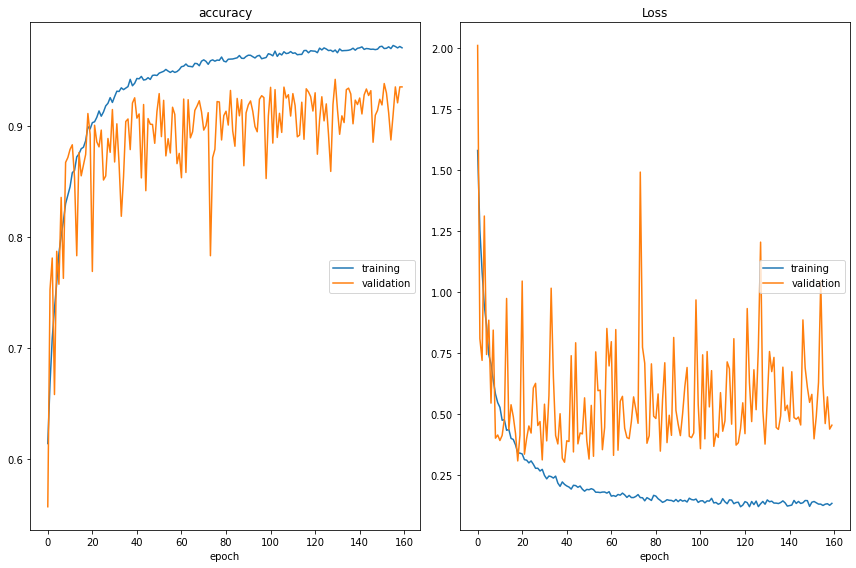

accuracy
	training         	 (min:    0.614, max:    0.973, cur:    0.970)
	validation       	 (min:    0.557, max:    0.942, cur:    0.935)
Loss
	training         	 (min:    0.122, max:    1.580, cur:    0.135)
	validation       	 (min:    0.304, max:    2.010, cur:    0.455)
221/221 - 18s - loss: 0.1354 - accuracy: 0.9704 - val_loss: 0.4555 - val_accuracy: 0.9352 - 18s/epoch - 83ms/step


In [ ]:
from livelossplot import PlotLossesKeras

epochs = 120
batchsize = 32
model_details = 'resnet50_{}_batch{}_epoch{}_data{}'.format(model_name,batchsize,epochs,dataset_name)
model_weights_path = '{}/{}.hdf5'.format(models_dir,model_details)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer, PlotLossesKeras()],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 47.3371%


## Transfer Learning with MobileNet V2

### Preparing the model

In [6]:
#  Define image size to use for given model
n_pixels = 224
# Define a model name for records
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [7]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

Preparing to create valid tensors


100%|██████████| 5292/5292 [00:07<00:00, 701.19it/s]


valid tensors prepared


In [9]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

Preparing to create test tensors


100%|██████████| 6384/6384 [00:09<00:00, 671.33it/s]


test tensors prepared


In [10]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

Preparing to create train tensors


100%|██████████| 14120/14120 [00:26<00:00, 540.01it/s]


train tensors prepared


### Extract Bottleneck Features for Training Set

In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Name & path of bottleneck features
feat_train_name = 'mobileNetV2_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load MobileNetV2 model + remove final classification layers
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtai n bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    # np.array()
    big_x_train = np.array([np.array(Image.fromarray((train_tensors[i]* 255).astype(np.uint8)).resize((n_pixels, n_pixels), 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    mobileNetV2_input_train = preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(mobileNetV2_input_train)
#     features = np.squeeze(features)
    np.savez(feat_train_path, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features detected (train)
bottleneck features saved (train)


### Extract Bottleneck Features for Validation Set

In [12]:
# Name & path of bottleneck features
feat_valid_name = 'mobileNetV2_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([np.array(Image.fromarray((valid_tensors[i]* 255).astype(np.uint8)).resize((n_pixels, n_pixels), 3)) 
                            for i in range(0, len(valid_tensors))]).astype('float32')

    mobileNetV2_input_valid = preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(mobileNetV2_input_valid)
#     features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_path, features_test=features_valid)
print('bottleneck features saved (valid)')

bottleneck features file not detected (valid)
calculating now ...
bottleneck features saved (valid)


### Extract Bottleneck Features for Test Set

In [13]:
# Name & path of bottleneck features
feat_test_name = 'mobileNetV2_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([np.array(Image.fromarray((test_tensors[i]* 255).astype(np.uint8)).resize((n_pixels, n_pixels), 3)) 
                            for i in range(0, len(test_tensors))]).astype('float32')

    mobileNetV2_input_test = preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(mobileNetV2_input_test)
#     features_test = np.squeeze(features_test)
    np.savez(feat_test_path, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


### Building model

In [15]:
# 3 CNN Layers
from keras.layers import MaxPooling2D

model = Sequential()

model.add(Conv2D(filters=512, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=2))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 6, 6, 512)         2621952   
                                                                 
 dropout_2 (Dropout)         (None, 6, 6, 512)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 256)         524544    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 256)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         131200    
                                                      

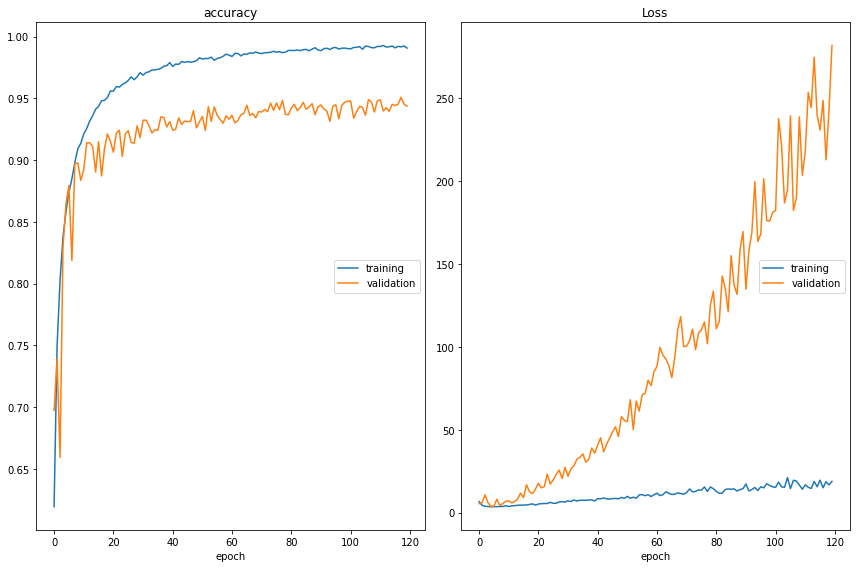

accuracy
	training         	 (min:    0.619, max:    0.993, cur:    0.991)
	validation       	 (min:    0.659, max:    0.951, cur:    0.944)
Loss
	training         	 (min:    3.570, max:   21.189, cur:   18.886)
	validation       	 (min:    3.883, max:  281.988, cur:  281.988)
442/442 [==============================] - 67s 151ms/step - loss: 18.8855 - accuracy: 0.9907 - val_loss: 281.9875 - val_accuracy: 0.9437


In [17]:
from livelossplot import PlotLossesKeras

epochs = 120
batchsize = 32
model_details = 'mobileNetV2_{}_batch{}_epoch{}_data{}'.format(model_name,batchsize,epochs,dataset_name)
model_weights_path = '{}/{}.hdf5'.format(models_dir,model_details)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer, PlotLossesKeras()],
          verbose=1, shuffle=True)          

### Evaluating the model

In [18]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 51.4568%


## Confusion Matrix of Test Data

After performing tests, a confusion matrix can be used to evaluate the model and it's accuracy for each ASL handshape/letter. Below we use the weight's from the last model defined and used above to generate our confusion matrix.

In [ ]:
# Load the weights of latest model run
model.load_weights(model_weights_path)

test_predictions = model.predict_classes(features_test)

12768/12782 [============================>.] - ETA: 0s

In [ ]:
sess = tf.Session()
# Change one-hot encoding to just an integer representing letter
un_hot_encode_targets = np.argmax(test_targets, axis=1)

confusion_arr = sess.run(tf.confusion_matrix(un_hot_encode_targets, test_predictions, 24))
# Get percents to compare with research paper benchmark
confusion_arr_percents = confusion_arr/sum(confusion_arr)

In [ ]:
# Note no 'J' & 'Z' were used
letters = "ABCDEFGHIKLMNOPQRSTUVWXY"

# Print out counts to see distribution of the number of letters tested against
for elem in ['{}: {}'.format(letter,count) for letter,count in zip(letters,sum(confusion_arr))]:
    print(elem)

A: 705
B: 586
C: 519
D: 461
E: 764
F: 450
G: 766
H: 185
I: 450
K: 494
L: 469
M: 453
N: 1239
O: 380
P: 526
Q: 285
R: 681
S: 513
T: 225
U: 671
V: 725
W: 519
X: 224
Y: 492


In [ ]:
# Save confusion matrix/array as CSVs for reference
np.savetxt('confusion_matrices/confusionMatrix_{}_counts.csv'.format(model_details),confusion_arr)
np.savetxt('confusion_matrices/confusionMatrix_{}_percent.csv'.format(model_details),confusion_arr_percents)

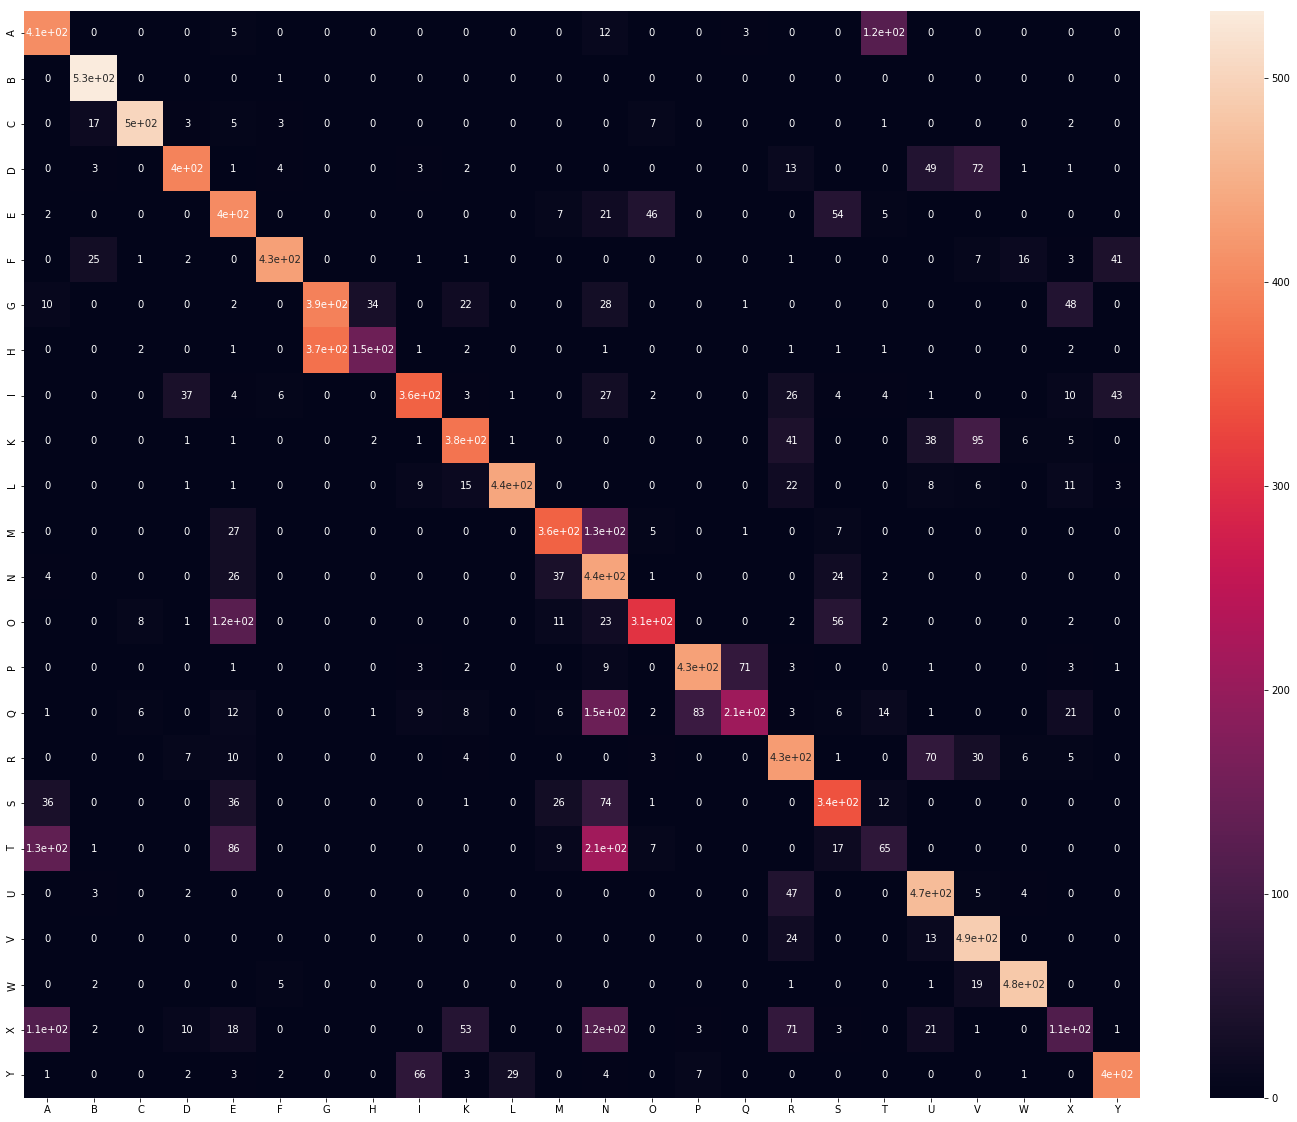

In [ ]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (25,20))
sn.heatmap(df_cm, annot=True)

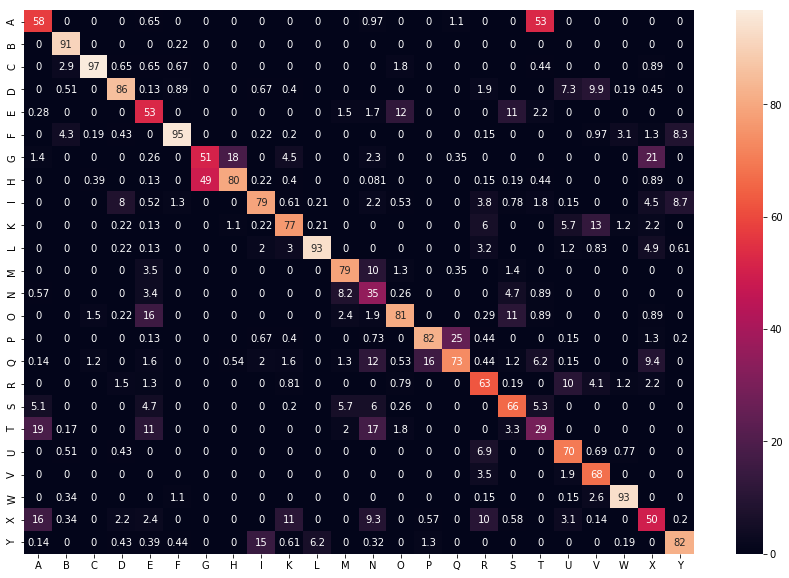

In [ ]:
# Percentages for confusion matrix
# Multiplied by 100 to make it easier to read values
df_cm = pd.DataFrame(confusion_arr_percents*100, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)